### Решение задачи классификации при помощи решающего дерева
Датасет `dataset/heart_disease_uci.csv`. Таргет `'num' >= 0` - болен ли пациент болезнью сердца. 

### Определим бейзлайн

In [201]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

heart_df = pd.read_csv('dataset/heart_disease_uci.csv')

heart_df['target'] = (heart_df['num'] > 0).astype(int)
heart_df = heart_df.drop(['id', 'dataset', 'num'], axis=1)
X_class = heart_df.drop(['target'], axis=1)
y_class = heart_df['target']

categorical_features = ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'thal']
numeric_features = [col for col in X_class.columns if col not in categorical_features]

preprocessor = ColumnTransformer(
    transformers=[
        ('num', SimpleImputer(strategy='mean'), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

dtc = DecisionTreeClassifier(random_state=42)
dt = Pipeline(steps=[('preprocessor', preprocessor),
                     ('classifier', dtc)])

X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(X_class, y_class, test_size=0.2, random_state=42, stratify=y_class)
dt.fit(X_train_c, y_train_c)

,steps,"[('preprocessor', ...), ('classifier', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [202]:
dtc.get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'random_state': 42,
 'splitter': 'best'}

In [203]:
y_pred_c = dt.predict(X_test_c)
print('Classification Baseline (Decision Tree):')
print('Accuracy:', accuracy_score(y_test_c, y_pred_c))
print('Precision:', precision_score(y_test_c, y_pred_c))
print('Recall:', recall_score(y_test_c, y_pred_c))
print('F1:', f1_score(y_test_c, y_pred_c))

Classification Baseline (Decision Tree):
Accuracy: 0.7663043478260869
Precision: 0.7757009345794392
Recall: 0.8137254901960784
F1: 0.7942583732057417


### Посмотрим на дерево бейзлайна

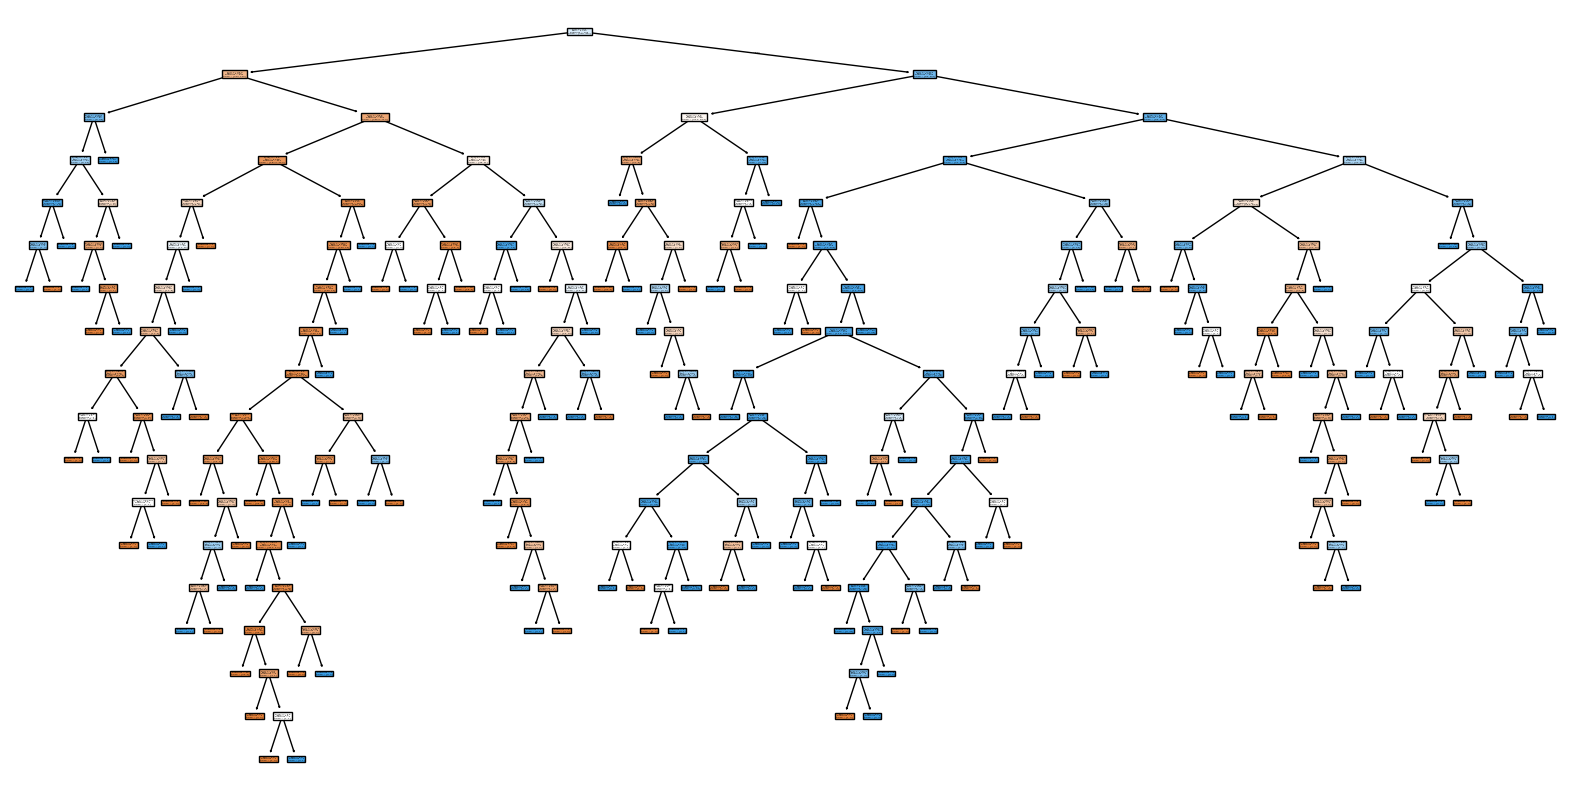

In [204]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plot_tree(dt.named_steps['classifier'], filled=True)
plt.show()

Как видно, дерево получилось слишком глубоким и переобученным. Попробуем улучшить полученные показатели метрик при помощи импутации пропусков средним значением, нормализации числовых качеств и подбором оптимальных параметров решаюшего дерева. 

In [205]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

preprocessor_improved = ColumnTransformer(
    transformers=[
        ('num', Pipeline([('imputer', SimpleImputer(strategy='mean')), ('scaler', StandardScaler())]), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

dt_improved = Pipeline(steps=[('preprocessor', preprocessor_improved),
                              ('classifier', DecisionTreeClassifier(random_state=42))])

param_grid_c = {
    'classifier__max_depth': [3, 5, 7, None],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4],
    'classifier__criterion': ['gini', 'entropy', 'log_loss']
}
grid_c = GridSearchCV(dt_improved, param_grid_c, cv=10, scoring='f1')
grid_c.fit(X_train_c, y_train_c)

print('Best params:', grid_c.best_params_)

Best params: {'classifier__criterion': 'gini', 'classifier__max_depth': 5, 'classifier__min_samples_leaf': 4, 'classifier__min_samples_split': 2}


In [214]:
dt_imp = Pipeline(steps=[('preprocessor', preprocessor_improved),
                              ('classifier', DecisionTreeClassifier(criterion='gini', 
                                                                    max_depth=5, 
                                                                    min_samples_leaf=4, 
                                                                    min_samples_split=2, 
                                                                    class_weight='balanced',
                                                                    random_state=42))])
dt_imp.fit(X_train_c, y_train_c)

,steps,"[('preprocessor', ...), ('classifier', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


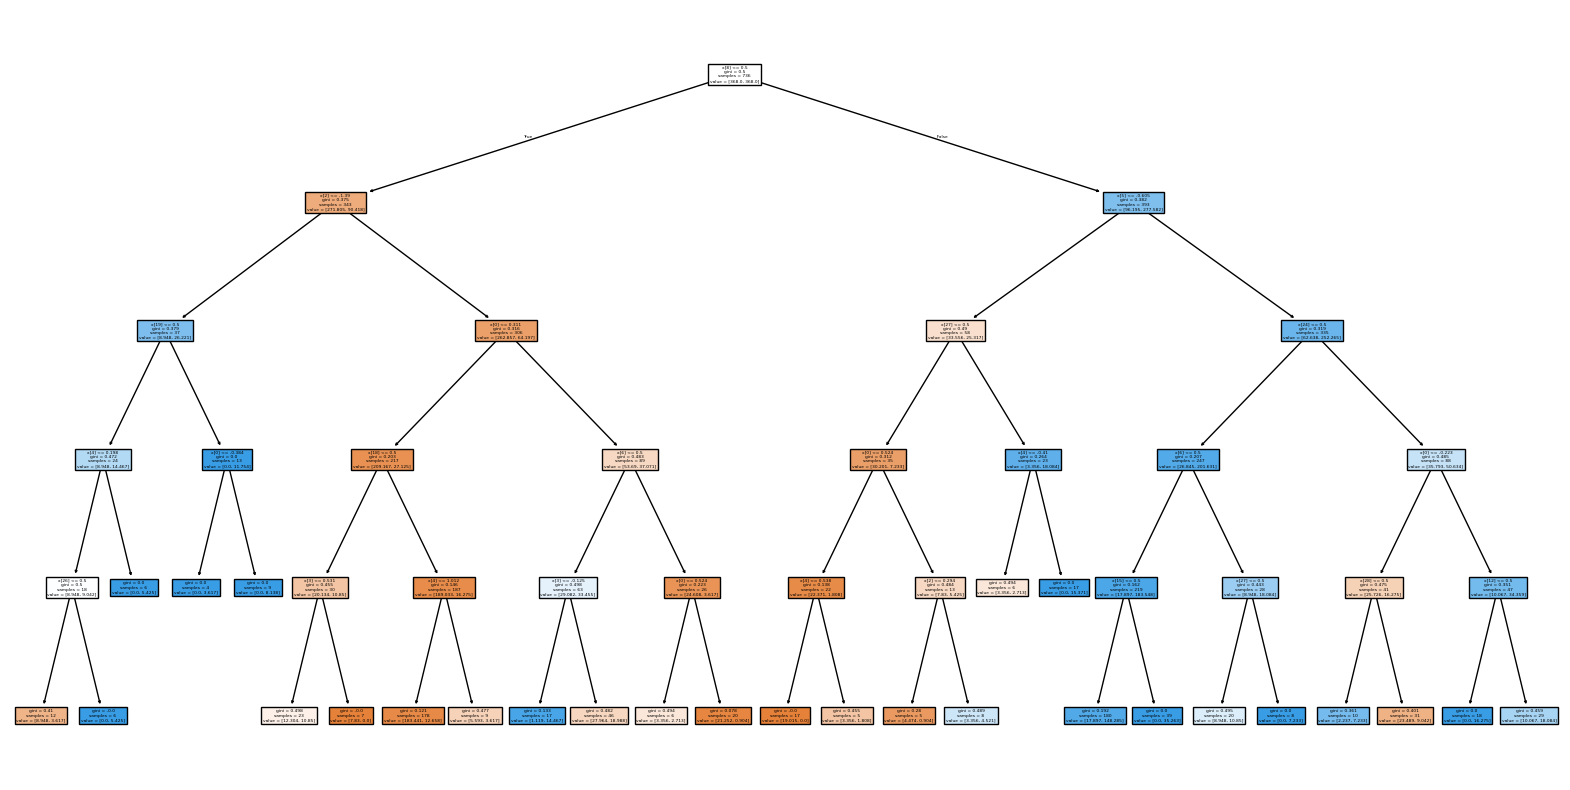

In [215]:
plt.figure(figsize=(20,10))
plot_tree(dt_imp.named_steps['classifier'], filled=True)
plt.show()

In [216]:
y_pred_c_imp = dt_imp.predict(X_test_c)
print('Improved Classification (Decision Tree):')
print('Accuracy:', accuracy_score(y_test_c, y_pred_c_imp))
print('Precision:', precision_score(y_test_c, y_pred_c_imp))
print('Recall:', recall_score(y_test_c, y_pred_c_imp))
print('F1:', f1_score(y_test_c, y_pred_c_imp))

Improved Classification (Decision Tree):
Accuracy: 0.8043478260869565
Precision: 0.8235294117647058
Recall: 0.8235294117647058
F1: 0.8235294117647058


### Сравним модели на k-фолде.

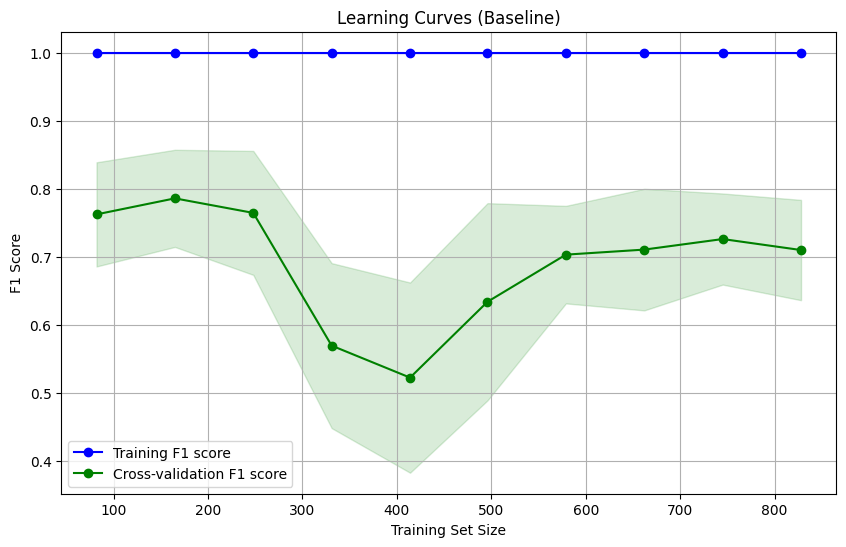

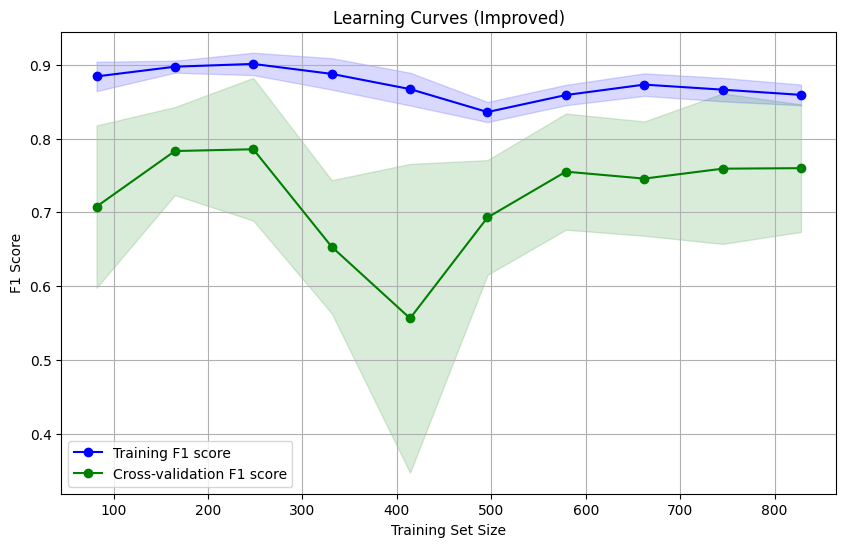

In [217]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve

def draw_learning_curve(dt_pipeline: Pipeline, name: str = 'Decision Tree Classifier'):
    train_sizes = np.linspace(0.1, 1.0, 10)

    train_sizes, train_scores, val_scores = learning_curve(
        estimator=dt_pipeline,
        X=X_class,
        y=y_class,
        cv=10,
        scoring='f1',
        train_sizes=train_sizes,
        random_state=42,
        n_jobs=-1
    )

    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    val_mean = np.mean(val_scores, axis=1)
    val_std = np.std(val_scores, axis=1)

    plt.figure(figsize=(10, 6))
    plt.plot(train_sizes, train_mean, label='Training F1 score', color='blue', marker='o')
    plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.15, color='blue')

    plt.plot(train_sizes, val_mean, label='Cross-validation F1 score', color='green', marker='o')
    plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, alpha=0.15, color='green')

    plt.title(f'Learning Curves ({name})')
    plt.xlabel('Training Set Size')
    plt.ylabel('F1 Score')
    plt.legend(loc='best')
    plt.grid(True)
    plt.show()

draw_learning_curve(dt, 'Baseline')
draw_learning_curve(dt_imp, 'Improved')

Как видно, без применения вышеперечисленных гипотез, дерево переобучается и на кросс-валидации показывает худшие результаты по сравнению с улучшенной версией.

### Далее реализуем решающее дерево вручную

In [218]:
import numpy as np

class DecisionTreeScratch:
    def __init__(self, max_depth=None, min_samples_split=2, min_samples_leaf=1, criterion='gini'):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.min_samples_leaf = min_samples_leaf
        self.criterion = criterion
        self.tree = None

    def fit(self, X, y):
        self.tree = self._build_tree(X, y, depth=0)

    def _build_tree(self, X, y, depth):
        n_samples, n_features = X.shape
        if (n_samples < self.min_samples_split or depth == self.max_depth or len(np.unique(y)) == 1 or n_samples < 2 * self.min_samples_leaf):
            return np.bincount(y).argmax()

        best_split = self._find_best_split(X, y)
        if best_split['impurity'] == 0:
            return np.bincount(y).argmax()

        left_idx = X[:, best_split['feature']] < best_split['threshold']
        right_idx = ~left_idx

        left_tree = self._build_tree(X[left_idx], y[left_idx], depth + 1)
        right_tree = self._build_tree(X[right_idx], y[right_idx], depth + 1)

        return {'feature': best_split['feature'], 'threshold': best_split['threshold'],
                'left': left_tree, 'right': right_tree}

    def _find_best_split(self, X, y):
        best = {'impurity': float('inf')}
        n_samples, n_features = X.shape
        for feature in range(n_features):
            thresholds = np.unique(X[:, feature])
            for threshold in thresholds:
                left_idx = X[:, feature] < threshold
                right_idx = ~left_idx
                if (sum(left_idx) < self.min_samples_leaf or sum(right_idx) < self.min_samples_leaf):
                    continue
                impurity = self._calculate_impurity(y[left_idx], y[right_idx])
                if impurity < best['impurity']:
                    best = {'feature': feature, 'threshold': threshold, 'impurity': impurity}
        return best

    def _calculate_impurity(self, y_left, y_right):
        if self.criterion == 'gini':
            imp_left = 1 - sum((np.bincount(y_left) / len(y_left))**2)
            imp_right = 1 - sum((np.bincount(y_right) / len(y_right))**2)
        else:
            raise ValueError('Unsupporter criterion') # реализуем только критерий Джини
        weight_left = len(y_left) / (len(y_left) + len(y_right))
        return weight_left * imp_left + (1 - weight_left) * imp_right

    def predict(self, X):
        return np.array([self._predict_sample(x, self.tree) for x in X])

    def _predict_sample(self, x, tree):
        if not isinstance(tree, dict):
            return tree
        if x[tree['feature']] < tree['threshold']:
            return self._predict_sample(x, tree['left'])
        else:
            return self._predict_sample(x, tree['right'])

X_train_c_num = preprocessor.fit_transform(X_train_c)
X_test_c_num = preprocessor.transform(X_test_c)

dt_scr = DecisionTreeScratch(max_depth=None, min_samples_split=2, min_samples_leaf=1, criterion='gini')
dt_scr.fit(X_train_c_num, y_train_c.values)

In [219]:
y_pred_c_scr = dt_scr.predict(X_test_c_num)
print('Scratch Classification (Decision Tree):')
print('Accuracy:', accuracy_score(y_test_c, y_pred_c_scr))
print('Precision:', precision_score(y_test_c, y_pred_c_scr))
print('Recall:', recall_score(y_test_c, y_pred_c_scr))
print('F1:', f1_score(y_test_c, y_pred_c_scr))

Scratch Classification (Decision Tree):
Accuracy: 0.7663043478260869
Precision: 0.7757009345794392
Recall: 0.8137254901960784
F1: 0.7942583732057417


### Применим вышеперечисленные гипотезы

In [222]:
X_train_c_imp = preprocessor_improved.fit_transform(X_train_c)
X_test_c_imp = preprocessor_improved.transform(X_test_c)

dt_scr_imp = DecisionTreeScratch(max_depth=5, min_samples_split=4, min_samples_leaf=2, criterion='gini')
dt_scr_imp.fit(X_train_c_imp, y_train_c.values)

In [223]:
y_pred_c_scr_imp = dt_scr_imp.predict(X_test_c_imp)
print('Scratch Improved Classification (Decision Tree):')
print('Accuracy:', accuracy_score(y_test_c, y_pred_c_scr_imp))
print('Precision:', precision_score(y_test_c, y_pred_c_scr_imp))
print('Recall:', recall_score(y_test_c, y_pred_c_scr_imp))
print('F1:', f1_score(y_test_c, y_pred_c_scr_imp))

Scratch Improved Classification (Decision Tree):
Accuracy: 0.8097826086956522
Precision: 0.819047619047619
Recall: 0.8431372549019608
F1: 0.8309178743961353


### Вывод
| Model             | Accuracy | Precision | Recall | F1   |
|-------------------|----------|-----------|--------|------|
|Baseline (sclearn) | 0.77     | 0.78      | 0.81   | 0.79 |
|Improved (sclearn) | 0.8      | 0.82      | 0.82   | 0.82 |
|Baseline (custom)  | 0.77     | 0.78      | 0.81   | 0.79 |
|Improved (custom)  | 0.81     | 0.82      | 0.84   | 0.83 |

Как видно по таблице, предложенные гипотезы смогли улучшить показатели целевых метрик относительно бейзлайна.